In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['Root10DaysSeedling', 'Shoot10DaysSeedling', 'Root35DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot35DaysSeedling', 
                 'Root14DaysSeedling', 'Root24DaysSeedling', 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot21DaysSeedling', 'PCC', 'Shoot14DaysSeedling', 'Root52DaysSeedling', 'Shoot17DaysSeedling', 
                 'Leaf21DaysSeedling', 'log_2FoldChange', 'ET', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

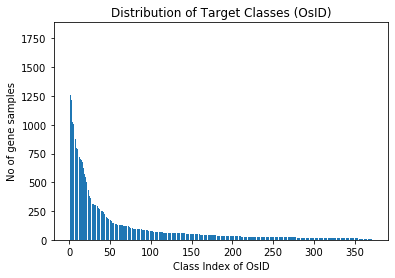

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=80, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

Number of input features: 1
Fold: 1


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 13s 4ms/step - loss: 5.0024 - accuracy: 0.0419 - val_loss: 4.9056 - val_accuracy: 0.0750
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.4130 - accuracy: 0.1030 - val_loss: 4.2112 - val_accuracy: 0.1186
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9325 - accuracy: 0.1482 - val_loss: 3.9450 - val_accuracy: 0.1743
Epoch 4/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6254 - accuracy: 0.1922 - val_loss: 3.6488 - val_accuracy: 0.1780
Epoch 5/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.3502 - accuracy: 0.2303 - val_loss: 3.3971 - val_accuracy: 0.2108
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1363 - accuracy: 0.2618 - val_loss: 3.2132 - val_accuracy: 0.2768
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9643 - accuracy: 0.2915 - val_loss: 3.0491 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 4.9763 - accuracy: 0.0509 - val_loss: 4.5972 - val_accuracy: 0.0935
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1317 - accuracy: 0.1434 - val_loss: 3.8574 - val_accuracy: 0.2180
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3460 - accuracy: 0.3184 - val_loss: 3.1874 - val_accuracy: 0.3745
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7133 - accuracy: 0.4334 - val_loss: 2.6544 - val_accuracy: 0.4387
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1951 - accuracy: 0.5109 - val_loss: 2.2118 - val_accuracy: 0.5116
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7956 - accuracy: 0.5594 - val_loss: 1.9609 - val_accuracy: 0.5523
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5437 - accuracy: 0.5995 - val_loss: 1.8233 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 4.7658 - accuracy: 0.0764 - val_loss: 4.1565 - val_accuracy: 0.1604
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5779 - accuracy: 0.2717 - val_loss: 3.4106 - val_accuracy: 0.3241
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9209 - accuracy: 0.4007 - val_loss: 2.8921 - val_accuracy: 0.4669
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4264 - accuracy: 0.4867 - val_loss: 2.5294 - val_accuracy: 0.5072
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0777 - accuracy: 0.5451 - val_loss: 2.2795 - val_accuracy: 0.5837
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8346 - accuracy: 0.5905 - val_loss: 2.1548 - val_accuracy: 0.5930
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6518 - accuracy: 0.6183 - val_loss: 2.0468 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 4.7697 - accuracy: 0.0940 - val_loss: 4.0324 - val_accuracy: 0.2306
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3306 - accuracy: 0.3359 - val_loss: 2.9918 - val_accuracy: 0.4290
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4755 - accuracy: 0.4765 - val_loss: 2.4202 - val_accuracy: 0.5410
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9487 - accuracy: 0.5646 - val_loss: 2.0577 - val_accuracy: 0.5954
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6051 - accuracy: 0.6226 - val_loss: 1.9092 - val_accuracy: 0.6130
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3809 - accuracy: 0.6652 - val_loss: 1.6591 - val_accuracy: 0.6737
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2460 - accuracy: 0.6916 - val_loss: 1.6702 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 4.6477 - accuracy: 0.0745 - val_loss: 4.1785 - val_accuracy: 0.1320
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5418 - accuracy: 0.2624 - val_loss: 3.1345 - val_accuracy: 0.4070
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5460 - accuracy: 0.4566 - val_loss: 2.4187 - val_accuracy: 0.5160
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9716 - accuracy: 0.5496 - val_loss: 2.0348 - val_accuracy: 0.5919
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6113 - accuracy: 0.6193 - val_loss: 1.7920 - val_accuracy: 0.6323
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3884 - accuracy: 0.6589 - val_loss: 1.5619 - val_accuracy: 0.6788
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2262 - accuracy: 0.6860 - val_loss: 1.4445 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 4.4915 - accuracy: 0.0866 - val_loss: 3.9403 - val_accuracy: 0.1232
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3263 - accuracy: 0.3180 - val_loss: 3.0697 - val_accuracy: 0.4279
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5166 - accuracy: 0.5049 - val_loss: 2.4871 - val_accuracy: 0.5085
Epoch 4/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9859 - accuracy: 0.5834 - val_loss: 2.1233 - val_accuracy: 0.5927
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6161 - accuracy: 0.6432 - val_loss: 1.8844 - val_accuracy: 0.6620
Epoch 6/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3584 - accuracy: 0.6881 - val_loss: 1.6675 - val_accuracy: 0.6887
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1970 - accuracy: 0.7114 - val_loss: 1.5745 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 9s 3ms/step - loss: 4.4861 - accuracy: 0.1031 - val_loss: 4.0048 - val_accuracy: 0.1536
Epoch 2/80
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4452 - accuracy: 0.2683 - val_loss: 3.2027 - val_accuracy: 0.3734
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.6881 - accuracy: 0.4303 - val_loss: 2.6576 - val_accuracy: 0.5263
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.1724 - accuracy: 0.5408 - val_loss: 2.2778 - val_accuracy: 0.5888
Epoch 5/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8001 - accuracy: 0.6128 - val_loss: 1.9922 - val_accuracy: 0.6451
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5426 - accuracy: 0.6499 - val_loss: 1.8031 - val_accuracy: 0.6706
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3572 - accuracy: 0.6753 - val_loss: 1.6991 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.4476 - accuracy: 0.0907 - val_loss: 3.9686 - val_accuracy: 0.1595
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5277 - accuracy: 0.1964 - val_loss: 3.3311 - val_accuracy: 0.2656
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6951 - accuracy: 0.4259 - val_loss: 2.4485 - val_accuracy: 0.5113
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8918 - accuracy: 0.5901 - val_loss: 1.8872 - val_accuracy: 0.6251
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4546 - accuracy: 0.6548 - val_loss: 1.5797 - val_accuracy: 0.6667
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2110 - accuracy: 0.6976 - val_loss: 1.3843 - val_accuracy: 0.7058
Epoch 7/80
1846/1846 [==============================] - 3s 2ms/step - loss: 1.0600 - accuracy: 0.7241 - val_loss: 1.2731 - val_accuracy: 0.7215
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.6323 - accuracy: 0.0707 - val_loss: 4.2552 - val_accuracy: 0.0961
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8756 - accuracy: 0.1253 - val_loss: 3.7029 - val_accuracy: 0.1325
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1745 - accuracy: 0.2981 - val_loss: 3.0626 - val_accuracy: 0.3758
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5137 - accuracy: 0.4628 - val_loss: 2.6033 - val_accuracy: 0.5177
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0436 - accuracy: 0.5636 - val_loss: 2.2444 - val_accuracy: 0.5749
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6852 - accuracy: 0.6308 - val_loss: 2.0204 - val_accuracy: 0.6387
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4380 - accuracy: 0.6748 - val_loss: 1.8936 - val_accuracy: 0.6748
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.4490 - accuracy: 0.1023 - val_loss: 3.9962 - val_accuracy: 0.1461
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6076 - accuracy: 0.1804 - val_loss: 3.4689 - val_accuracy: 0.1855
Epoch 3/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9710 - accuracy: 0.3251 - val_loss: 2.8295 - val_accuracy: 0.3518
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2843 - accuracy: 0.4904 - val_loss: 2.2945 - val_accuracy: 0.5217
Epoch 5/80
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8084 - accuracy: 0.5773 - val_loss: 1.9832 - val_accuracy: 0.6004
Epoch 6/80
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4837 - accuracy: 0.6454 - val_loss: 1.7142 - val_accuracy: 0.6356
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2749 - accuracy: 0.6831 - val_loss: 1.5394 - val_accuracy: 0.7111
Epo

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 14s 4ms/step - loss: 4.5010 - accuracy: 0.0943 - val_loss: 4.0382 - val_accuracy: 0.1347
Epoch 2/80
1846/1846 [==============================] - 8s 5ms/step - loss: 3.6131 - accuracy: 0.1855 - val_loss: 3.4880 - val_accuracy: 0.2337
Epoch 3/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9928 - accuracy: 0.3471 - val_loss: 2.8992 - val_accuracy: 0.4488
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3660 - accuracy: 0.4923 - val_loss: 2.4307 - val_accuracy: 0.5430
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.9132 - accuracy: 0.5760 - val_loss: 2.0996 - val_accuracy: 0.6092
Epoch 6/80
1846/1846 [==============================] - 8s 5ms/step - loss: 1.5931 - accuracy: 0.6380 - val_loss: 1.8767 - val_accuracy: 0.6464
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.3618 - accuracy: 0.6852 - val_loss: 1.7067 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 16s 6ms/step - loss: 4.5301 - accuracy: 0.0792 - val_loss: 4.1396 - val_accuracy: 0.1043
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7405 - accuracy: 0.1716 - val_loss: 3.5781 - val_accuracy: 0.1974
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0263 - accuracy: 0.3098 - val_loss: 2.8312 - val_accuracy: 0.4251
Epoch 4/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.3181 - accuracy: 0.4720 - val_loss: 2.3003 - val_accuracy: 0.4856
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.8575 - accuracy: 0.5439 - val_loss: 1.9437 - val_accuracy: 0.5668
Epoch 6/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.5830 - accuracy: 0.5968 - val_loss: 1.7246 - val_accuracy: 0.6200
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.3981 - accuracy: 0.6381 - val_loss: 1.5852 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 5ms/step - loss: 4.5674 - accuracy: 0.0810 - val_loss: 4.1158 - val_accuracy: 0.1393
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.6366 - accuracy: 0.1834 - val_loss: 3.4307 - val_accuracy: 0.2647
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.8871 - accuracy: 0.3748 - val_loss: 2.7725 - val_accuracy: 0.4601
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3246 - accuracy: 0.4928 - val_loss: 2.3904 - val_accuracy: 0.5063
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.9459 - accuracy: 0.5538 - val_loss: 2.0332 - val_accuracy: 0.5762
Epoch 6/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6469 - accuracy: 0.6054 - val_loss: 1.8162 - val_accuracy: 0.6205
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4255 - accuracy: 0.6462 - val_loss: 1.6228 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 14s 5ms/step - loss: 4.5132 - accuracy: 0.0842 - val_loss: 4.1288 - val_accuracy: 0.1395
Epoch 2/80
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7813 - accuracy: 0.1547 - val_loss: 3.7256 - val_accuracy: 0.1630
Epoch 3/80
1846/1846 [==============================] - 8s 4ms/step - loss: 3.4041 - accuracy: 0.2152 - val_loss: 3.3909 - val_accuracy: 0.2348
Epoch 4/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.9913 - accuracy: 0.3001 - val_loss: 2.9229 - val_accuracy: 0.3406
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.4766 - accuracy: 0.4442 - val_loss: 2.5254 - val_accuracy: 0.4759
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0883 - accuracy: 0.5225 - val_loss: 2.2741 - val_accuracy: 0.5336
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7903 - accuracy: 0.5778 - val_loss: 2.0069 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 16s 5ms/step - loss: 4.5286 - accuracy: 0.0835 - val_loss: 4.0599 - val_accuracy: 0.1206
Epoch 2/80
1846/1846 [==============================] - 9s 5ms/step - loss: 3.6369 - accuracy: 0.1771 - val_loss: 3.4670 - val_accuracy: 0.2200
Epoch 3/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.9983 - accuracy: 0.3201 - val_loss: 2.8711 - val_accuracy: 0.3690
Epoch 4/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.4641 - accuracy: 0.4221 - val_loss: 2.5037 - val_accuracy: 0.4508
Epoch 5/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.0983 - accuracy: 0.4912 - val_loss: 2.2669 - val_accuracy: 0.4865
Epoch 6/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.8308 - accuracy: 0.5415 - val_loss: 2.0638 - val_accuracy: 0.5349
Epoch 7/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.6175 - accuracy: 0.5818 - val_loss: 1.8668 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 16s 5ms/step - loss: 4.9334 - accuracy: 0.0542 - val_loss: 4.4519 - val_accuracy: 0.0882
Epoch 2/80
1846/1846 [==============================] - 8s 4ms/step - loss: 4.0410 - accuracy: 0.1274 - val_loss: 3.9113 - val_accuracy: 0.1514
Epoch 3/80
1846/1846 [==============================] - 9s 5ms/step - loss: 3.5067 - accuracy: 0.2238 - val_loss: 3.4272 - val_accuracy: 0.3276
Epoch 4/80
1846/1846 [==============================] - 8s 5ms/step - loss: 2.9936 - accuracy: 0.3724 - val_loss: 3.0064 - val_accuracy: 0.4334
Epoch 5/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.5535 - accuracy: 0.4562 - val_loss: 2.6362 - val_accuracy: 0.4873
Epoch 6/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.2041 - accuracy: 0.5220 - val_loss: 2.4136 - val_accuracy: 0.5452
Epoch 7/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.9545 - accuracy: 0.5598 - val_loss: 2.2028 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 14s 5ms/step - loss: 4.6316 - accuracy: 0.0746 - val_loss: 4.1622 - val_accuracy: 0.1199
Epoch 2/80
1846/1846 [==============================] - 8s 5ms/step - loss: 3.7886 - accuracy: 0.1532 - val_loss: 3.6584 - val_accuracy: 0.1520
Epoch 3/80
1846/1846 [==============================] - 8s 5ms/step - loss: 3.1663 - accuracy: 0.2973 - val_loss: 3.0331 - val_accuracy: 0.3734
Epoch 4/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.5329 - accuracy: 0.4452 - val_loss: 2.5175 - val_accuracy: 0.4706
Epoch 5/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.0928 - accuracy: 0.5165 - val_loss: 2.1827 - val_accuracy: 0.5358
Epoch 6/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7665 - accuracy: 0.5874 - val_loss: 1.9492 - val_accuracy: 0.5857
Epoch 7/80
1846/1846 [==============================] - 9s 5ms/step - loss: 1.5234 - accuracy: 0.6294 - val_loss: 1.7246 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 15s 5ms/step - loss: 4.7888 - accuracy: 0.0626 - val_loss: 4.2733 - val_accuracy: 0.1063
Epoch 2/80
1846/1846 [==============================] - 8s 5ms/step - loss: 3.8607 - accuracy: 0.1535 - val_loss: 3.7008 - val_accuracy: 0.1842
Epoch 3/80
1846/1846 [==============================] - 8s 5ms/step - loss: 3.3107 - accuracy: 0.2390 - val_loss: 3.1431 - val_accuracy: 0.3146
Epoch 4/80
1846/1846 [==============================] - 9s 5ms/step - loss: 2.7186 - accuracy: 0.3761 - val_loss: 2.6282 - val_accuracy: 0.4209
Epoch 5/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.2843 - accuracy: 0.4699 - val_loss: 2.3052 - val_accuracy: 0.5072
Epoch 6/80
1846/1846 [==============================] - 8s 4ms/step - loss: 2.0029 - accuracy: 0.5208 - val_loss: 2.1966 - val_accuracy: 0.4873
Epoch 7/80
1846/1846 [==============================] - 8s 4ms/step - loss: 1.8140 - accuracy: 0.5540 - val_loss: 1.9773 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 10s 4ms/step - loss: 4.7946 - accuracy: 0.0613 - val_loss: 4.3349 - val_accuracy: 0.1182
Epoch 2/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9092 - accuracy: 0.1473 - val_loss: 3.7260 - val_accuracy: 0.1637
Epoch 3/80
1846/1846 [==============================] - 6s 4ms/step - loss: 3.3281 - accuracy: 0.2263 - val_loss: 3.1874 - val_accuracy: 0.2686
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7608 - accuracy: 0.3563 - val_loss: 2.6701 - val_accuracy: 0.4062
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2776 - accuracy: 0.4634 - val_loss: 2.2961 - val_accuracy: 0.4708
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9463 - accuracy: 0.5199 - val_loss: 2.0679 - val_accuracy: 0.5113
Epoch 7/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7281 - accuracy: 0.5577 - val_loss: 1.8442 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/80
1846/1846 [==============================] - 10s 4ms/step - loss: 4.8223 - accuracy: 0.0630 - val_loss: 4.5110 - val_accuracy: 0.1012
Epoch 2/80
1846/1846 [==============================] - 6s 3ms/step - loss: 4.1538 - accuracy: 0.1246 - val_loss: 3.9701 - val_accuracy: 0.1707
Epoch 3/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6780 - accuracy: 0.1868 - val_loss: 3.6657 - val_accuracy: 0.1630
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3748 - accuracy: 0.2102 - val_loss: 3.3970 - val_accuracy: 0.2176
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1278 - accuracy: 0.2507 - val_loss: 3.1806 - val_accuracy: 0.2636
Epoch 6/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8689 - accuracy: 0.3020 - val_loss: 2.9417 - val_accuracy: 0.3248
Epoch 7/80
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6181 - accuracy: 0.3522 - val_loss: 2.7141 - val_accuracy

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

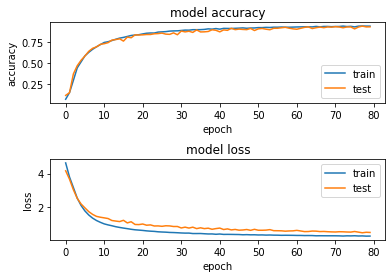

Final Test Accuracy: 0.942212700843811


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       0.92      1.00      0.96       384
           4       0.99      1.00      0.99       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.99      1.00      0.99       294
           9       0.99      1.00      0.99       269
          10       1.00      1.00      1.00       296
          11       0.95      1.00      0.97       258
          12       1.00      1.00      1.00       247
          13       0.96      1.00      0.98       237
          14       0.92      1.00      0.96       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os03g0363600         334               48       False
1  Os01g0173100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.443
1,2,0.837
2,3,0.829
3,4,0.870
4,5,0.923
5,6,0.901
6,7,0.894
7,8,0.922
8,9,0.888
9,10,0.935
